# U.S Permanent Visa Application Result Prediction

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data Preprocessing

In [2]:
#Read Data
perm = pd.read_csv('us_perm_visas.csv')

In [3]:
#Columns and missing values
perm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192648 entries, 0 to 192647
Data columns (total 14 columns):
case_received_date               192648 non-null object
case_received_year               192648 non-null int64
case_status                      192648 non-null object
class_of_admission               192648 non-null object
H1B                              161362 non-null float64
Immigrants Visa                  2414 non-null float64
country_of_citizenship           192648 non-null object
Date Interval                    192648 non-null int64
decision_date                    192648 non-null object
employer_num_employees           192641 non-null float64
foreign_worker_info_education    192648 non-null object
foreign_worker_info_state        192648 non-null object
wage_offer_from_9089             192648 non-null int64
wage_offer_unit_of_pay_9089      192648 non-null object
dtypes: float64(3), int64(3), object(8)
memory usage: 20.6+ MB


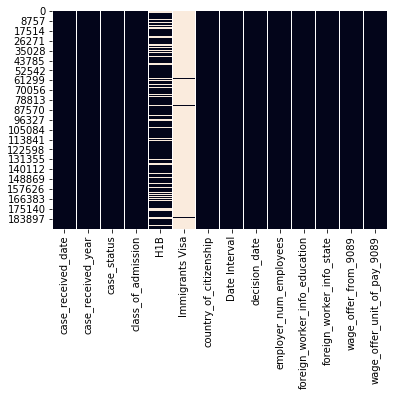

In [4]:
#Visualizing Missing Values
sns.heatmap(perm.isnull(),cbar=False)

In H1B column, the missing values are those applicants who are not H1B holder, so I decide to fill it to 0. And immigrants have more than 98% missing values, so I decided to drop that columns

In [5]:
perm['H1B'].fillna(0, inplace=True)
perm = perm.drop(perm.columns[5], axis = 1)

In [6]:
perm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192648 entries, 0 to 192647
Data columns (total 13 columns):
case_received_date               192648 non-null object
case_received_year               192648 non-null int64
case_status                      192648 non-null object
class_of_admission               192648 non-null object
H1B                              192648 non-null float64
country_of_citizenship           192648 non-null object
Date Interval                    192648 non-null int64
decision_date                    192648 non-null object
employer_num_employees           192641 non-null float64
foreign_worker_info_education    192648 non-null object
foreign_worker_info_state        192648 non-null object
wage_offer_from_9089             192648 non-null int64
wage_offer_unit_of_pay_9089      192648 non-null object
dtypes: float64(2), int64(3), object(8)
memory usage: 19.1+ MB


Now only employer size has 7 missing values, it is easy to drop those 7 rows since it accounts for very small part.

In [7]:
perm = perm.dropna(how='any').reset_index(drop = 'True')
perm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192641 entries, 0 to 192640
Data columns (total 13 columns):
case_received_date               192641 non-null object
case_received_year               192641 non-null int64
case_status                      192641 non-null object
class_of_admission               192641 non-null object
H1B                              192641 non-null float64
country_of_citizenship           192641 non-null object
Date Interval                    192641 non-null int64
decision_date                    192641 non-null object
employer_num_employees           192641 non-null float64
foreign_worker_info_education    192641 non-null object
foreign_worker_info_state        192641 non-null object
wage_offer_from_9089             192641 non-null int64
wage_offer_unit_of_pay_9089      192641 non-null object
dtypes: float64(2), int64(3), object(8)
memory usage: 19.1+ MB


## 2. Data Visualization

10 Countries with most Greencard applications

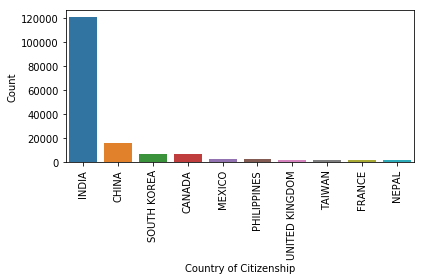

In [8]:
Country = pd.DataFrame(perm.groupby('country_of_citizenship')['H1B'].count()).reset_index()
Country['Count'] = Country['H1B']
Country['Country of Citizenship'] = Country['country_of_citizenship']
Country = Country.sort_values('Count',ascending = False)
Count = sns.barplot(x='Country of Citizenship',y='Count', data = Country[:10])
Count.set_xticklabels(Count.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

Applicants' visa type visualization

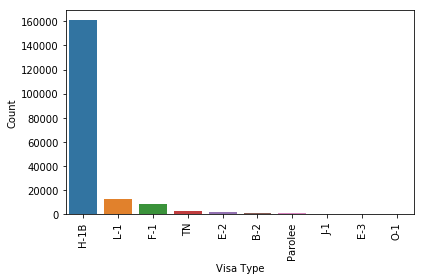

In [9]:
Visa = pd.DataFrame(perm.groupby('class_of_admission')['H1B'].count()).reset_index()
Visa['Count'] = Visa['H1B']
Visa['Visa Type'] = Visa['class_of_admission']
Visa = Visa.sort_values('Count',ascending = False)
Visa_Count = sns.barplot(x='Visa Type',y='Count', data = Visa[:10])
Visa_Count.set_xticklabels(Visa_Count.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

# 3. Data Preprocessing II

Since it is useless to transform all 187 citizenships to dummies. Here I decide to only choose applicants whose citizenship is Chinese. Besides, it is meaningless to predict applications which are withdrawn and expired. I will focus on certified and denied applications.

In [10]:
perm = perm[perm.country_of_citizenship == 'CHINA']
perm = perm[(perm.case_status == 'Denied')|(perm.case_status == 'Certified')|(perm.case_status == 'Not Certified')]
#Drop some other columns that will not be used in prediction models
perm = perm.drop(['case_received_date','class_of_admission',
                  'decision_date','country_of_citizenship',
                  'foreign_worker_info_state','wage_offer_unit_of_pay_9089'],axis =1 )

Transform the case_status to certified and denied.

In [11]:
perm[['case_status']] = perm[['case_status']].replace(to_replace = 'Not Certified',value = 'Denied')

Create dummies for education levels and case received year

In [12]:
perm = pd.get_dummies(data= perm, columns=['foreign_worker_info_education','case_received_year'])
perm = perm.reset_index(drop=True)

Transform certified and denied to 1 and 0.

In [13]:
perm[['case_status']] = perm[['case_status']].replace(to_replace = ['Certified','Denied'],value=[1,0])


Create correlation plot and histogram for each column

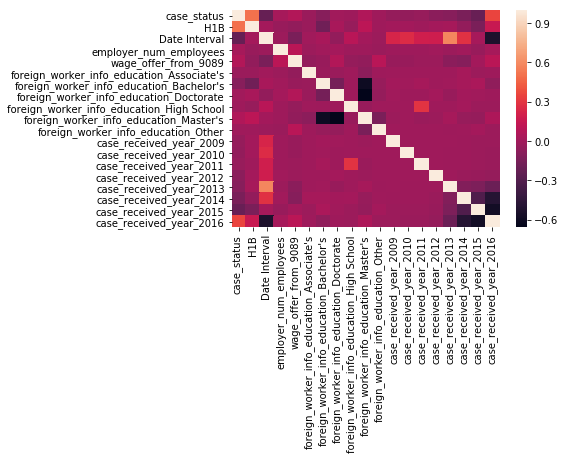

In [14]:
corr = perm.corr()
sns.heatmap(corr)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002201A3EACF8>,
      dtype=object)

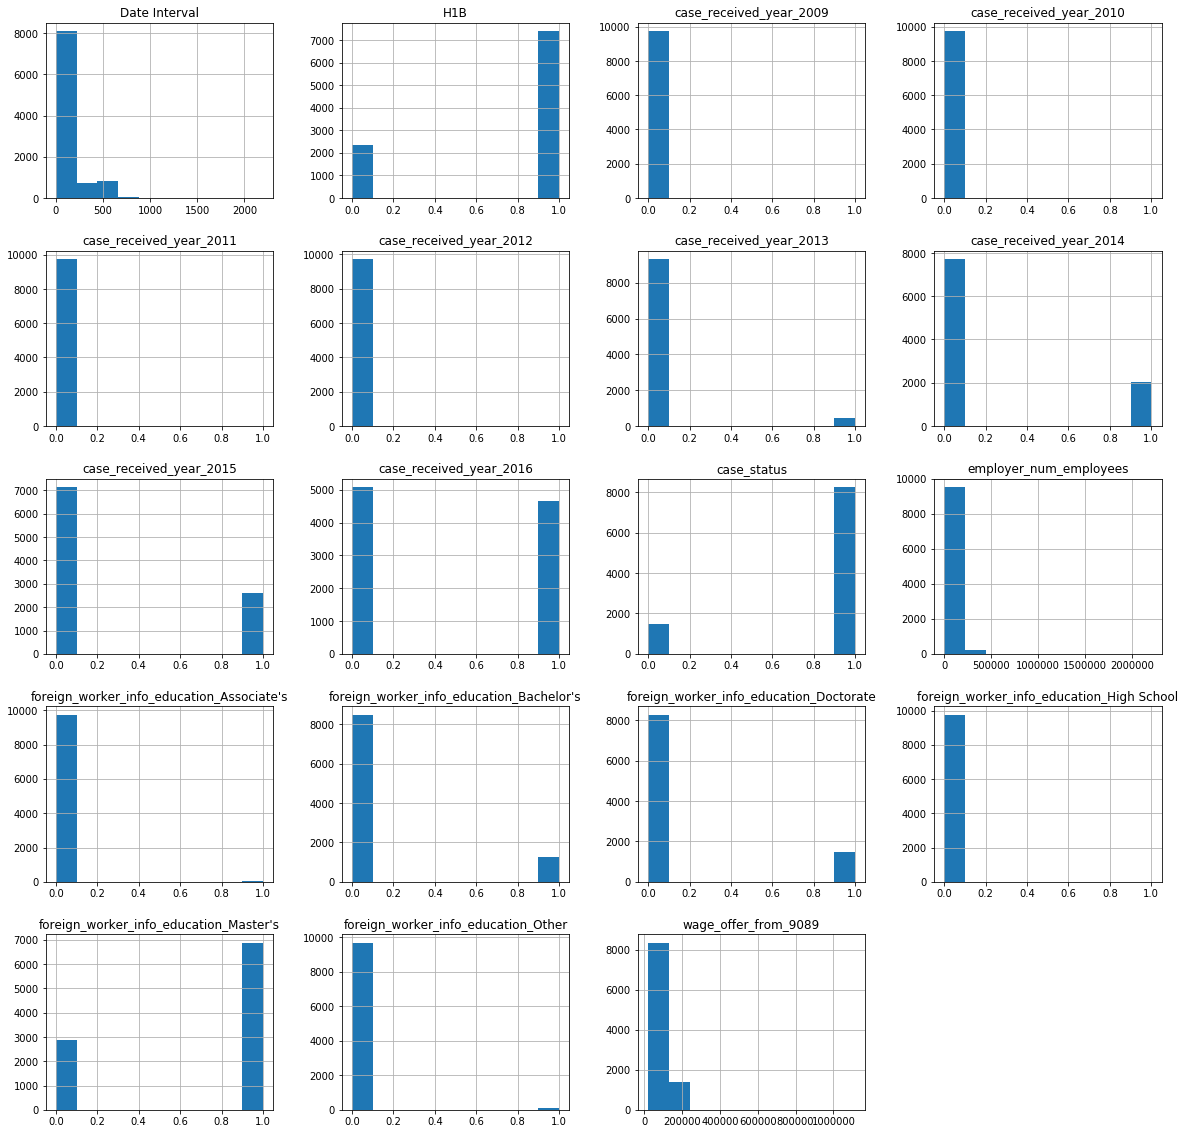

In [15]:
perm.hist(figsize=(20,20))

In [16]:
#Drop some columns that will not be used
perm = perm.drop(perm.iloc[:, [5,8,10,11,12,13,14]],axis=1)

Final Data

In [17]:
perm.head()

,case_status,H1B,Date Interval,employer_num_employees,wage_offer_from_9089,foreign_worker_info_education_Bachelor's,foreign_worker_info_education_Doctorate,foreign_worker_info_education_Master's,case_received_year_2013,case_received_year_2014,case_received_year_2015,case_received_year_2016
0,1,0.0,214,15.0,20000,1,0,0,0,0,1,0
1,1,0.0,510,1400.0,20342,1,0,0,0,1,0,0
2,1,0.0,508,1400.0,20342,0,0,1,0,1,0,0
3,1,0.0,204,3.0,25667,1,0,0,0,0,1,0
4,0,0.0,178,55.0,25709,0,0,1,0,0,1,0


## 4. Model

### Standardization

In [18]:
from sklearn.preprocessing import StandardScaler
Input = perm[['Date Interval','employer_num_employees','wage_offer_from_9089']]
scaler = StandardScaler()
scaler.fit(Input.values)
features = scaler.transform(Input.values)
Input = perm[['Date Interval','employer_num_employees','wage_offer_from_9089']]
perm[['Date Interval','employer_num_employees','wage_offer_from_9089']] = features

### Partition

In [19]:
from sklearn.model_selection import train_test_split
x = np.array(perm.drop('case_status',axis = 1))
y = np.array(perm.case_status)
x_train,x_test = train_test_split(x,test_size=0.3, random_state=1)
y_train,y_test = train_test_split(y,test_size=0.3, random_state=1)

### Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
LogisticRegression = LogisticRegression()
LogisticRegression.fit(x_train,y_train)

C:\Users\lzd05\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
y_pred_log = LogisticRegression.predict(x_test)
Acc1 = accuracy_score(y_test,y_pred_log)
Acc1

0.913905022207038

### KNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [23]:
from sklearn.model_selection import GridSearchCV
hyperparameters = {'n_neighbors' : range(1,10,1),
                   'leaf_size' : range(1,10,1)}
GridSearch_KNN = GridSearchCV(knn, hyperparameters, cv=10)
GridSearch_KNN.fit(x_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': range(1, 10), 'leaf_size': range(1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [24]:
#The best parameter that will be used 
GridSearch_KNN.best_params_

{'leaf_size': 1, 'n_neighbors': 3}

In [25]:
y_pred_KNN = GridSearch_KNN.predict(x_test)
Acc2 = accuracy_score(y_test,y_pred_KNN)
Acc2

0.9248377177997951

### Classification Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [27]:
y_pred_Tree = tree.predict(x_test)
Acc3 = accuracy_score(y_test,y_pred_Tree)
Acc3

0.9166381961052272

### Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier()
randomforest.fit(x_train,y_train)

C:\Users\lzd05\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [29]:
from sklearn.model_selection import GridSearchCV
parameters = {'bootstrap':[True],
              'n_estimators':[50,100,150,200,250,300,350,400,450,500],
              'max_depth': [70],
              'max_features': ['auto'],
              'min_samples_leaf': [4],
              'min_samples_split': [10]}
GridSearch_rf = GridSearchCV(estimator=randomforest,param_grid =parameters,cv=5)
GridSearch_rf.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'bootstrap': [True], 'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_depth': [70], 'max_features': ['auto'], 'min_samples_leaf': [4], 'min_samples_split': [10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [30]:
#The best parameter that will be used 
GridSearch_rf.best_params_

{'bootstrap': True,
 'max_depth': 70,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 150}

In [31]:
y_pred_forest= GridSearch_rf.predict(x_test)
Acc4 = accuracy_score(y_test,y_pred_forest)
Acc4

0.9285958319098052

### xgboost

In [32]:
from xgboost import XGBClassifier
xgboost = XGBClassifier()
xgboost.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [33]:
parameters_xgb = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators' : [50,100,150,200,250,300,350,400,450,500]}
GridSearchXGB = GridSearchCV(xgboost,parameters_xgb,cv=5)
GridSearchXGB.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'nthread': [4], 'objective': ['binary:logistic'], 'learning_rate': [0.03, 0.05, 0.07], 'max_depth': [5, 6, 7], 'min_child_weight': [4], 'silent': [1], 'subsample': [0.7], 'colsample_bytree': [0.7], 'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [34]:
#The best parameter that will be used 
GridSearchXGB.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 7,
 'min_child_weight': 4,
 'n_estimators': 200,
 'nthread': 4,
 'objective': 'binary:logistic',
 'silent': 1,
 'subsample': 0.7}

In [35]:
y_pred_xgb = GridSearchXGB.predict(x_test)
Acc5 = accuracy_score(y_test,y_pred_xgb)
Acc5

0.9309873590707208

### Deep Learning (Neural net)

### Model 1 (No Regularization)

In [36]:
from keras import models 
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras import regularizers

model1 = models.Sequential()
model1.add(layers.Dense(16,activation='relu',input_shape=(11,)))
model1.add(layers.Dense(16,activation='relu'))
model1.add(layers.Dense(1,activation='sigmoid'))
model1.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

C:\Users\lzd05\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


In [37]:
x_train_keras = x_train[:5000]
x_val = x_train[5000:]
y_train_keras = y_train[:5000]
y_val = y_train[5000:]

In [38]:
history1 = model1.fit(x_train_keras,y_train_keras,epochs =20,validation_data = (x_val,y_val))

Train on 5000 samples, validate on 1829 samples
Epoch 1/20
5000/5000 [==============================] - 0s 89us/step - loss: 0.3846 - accuracy: 0.8374 - val_loss: 0.3023 - val_accuracy: 0.8469
Epoch 2/20
5000/5000 [==============================] - 0s 53us/step - loss: 0.2703 - accuracy: 0.8752 - val_loss: 0.2547 - val_accuracy: 0.8901
Epoch 3/20
5000/5000 [==============================] - 0s 82us/step - loss: 0.2387 - accuracy: 0.9040 - val_loss: 0.2393 - val_accuracy: 0.9054
Epoch 4/20
5000/5000 [==============================] - 1s 107us/step - loss: 0.2281 - accuracy: 0.9098 - val_loss: 0.2359 - val_accuracy: 0.9120
Epoch 5/20
5000/5000 [==============================] - 1s 145us/step - loss: 0.2224 - accuracy: 0.9108 - val_loss: 0.2329 - val_accuracy: 0.9114
Epoch 6/20
5000/5000 [==============================] - 1s 146us/step - loss: 0.2187 - accuracy: 0.9108 - val_loss: 0.2322 - val_accuracy: 0.9153
Epoch 7/20
5000/5000 [==============================] - 1s 140us/step - loss: 0

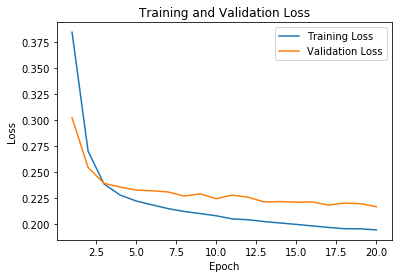

In [39]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epoch = range(1,21)
plt.plot(epoch,loss,label='Training Loss')
plt.plot(epoch,val_loss,label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

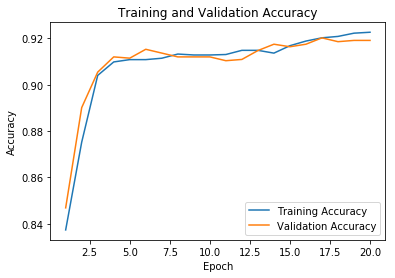

In [40]:
accuracy1 = history1.history['accuracy']
val_accuracy1 = history1.history['val_accuracy']
epoch = range(1,21)
plt.plot(epoch,accuracy1,label='Training Accuracy')
plt.plot(epoch,val_accuracy1,label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [41]:
results1 = model1.evaluate(x_test,y_test)
results1

2927/2927 [==============================] - 0s 21us/step


[0.21769328580085515, 0.9180048108100891]

### Model 2 (Add Dropout)

In [42]:
model2 = models.Sequential()
model2.add(layers.Dense(16,activation='relu',input_shape=(11,)))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(16,activation='relu'))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(1,activation='sigmoid'))
model2.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [43]:
history2 = model2.fit(x_train_keras,y_train_keras,epochs =20,validation_data = (x_val,y_val))

Train on 5000 samples, validate on 1829 samples
Epoch 1/20
5000/5000 [==============================] - 1s 100us/step - loss: 0.5551 - accuracy: 0.7048 - val_loss: 0.3631 - val_accuracy: 0.8480
Epoch 2/20
5000/5000 [==============================] - 1s 153us/step - loss: 0.3427 - accuracy: 0.8556 - val_loss: 0.2910 - val_accuracy: 0.8540
Epoch 3/20
5000/5000 [==============================] - 1s 139us/step - loss: 0.2924 - accuracy: 0.8628 - val_loss: 0.2604 - val_accuracy: 0.8792
Epoch 4/20
5000/5000 [==============================] - 1s 166us/step - loss: 0.2699 - accuracy: 0.8824 - val_loss: 0.2534 - val_accuracy: 0.8890
Epoch 5/20
5000/5000 [==============================] - 1s 163us/step - loss: 0.2708 - accuracy: 0.8930 - val_loss: 0.2465 - val_accuracy: 0.9016
Epoch 6/20
5000/5000 [==============================] - 1s 163us/step - loss: 0.2569 - accuracy: 0.8986 - val_loss: 0.2449 - val_accuracy: 0.9038
Epoch 7/20
5000/5000 [==============================] - 1s 163us/step - loss

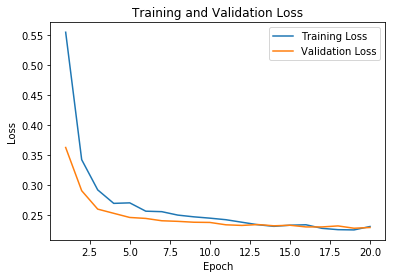

In [44]:
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch = range(1,21)
plt.plot(epoch,loss2,label='Training Loss')
plt.plot(epoch,val_loss2,label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

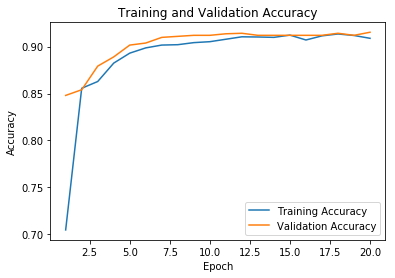

In [45]:
accuracy2 = history2.history['accuracy']
val_accuracy2 = history2.history['val_accuracy']
epoch = range(1,21)
plt.plot(epoch,accuracy2,label='Training Accuracy')
plt.plot(epoch,val_accuracy2,label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [46]:
results2 = model2.evaluate(x_test,y_test)
results2

2927/2927 [==============================] - 0s 22us/step


[0.23183082729618745, 0.9128800630569458]

### Model 3 (L2 Regularization)

In [47]:
model3 = models.Sequential()
model3.add(layers.Dense(16,activity_regularizer = regularizers.l2(0.001),activation='relu',input_shape=(11,)))
model3.add(layers.Dense(16,activity_regularizer = regularizers.l2(0.001),activation='relu'))
model3.add(layers.Dense(1,activation='sigmoid'))
model3.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [48]:
history3 = model3.fit(x_train_keras,y_train_keras,epochs =20,validation_data = (x_val,y_val))

Train on 5000 samples, validate on 1829 samples
Epoch 1/20
5000/5000 [==============================] - 0s 81us/step - loss: 0.7190 - accuracy: 0.7174 - val_loss: 0.4846 - val_accuracy: 0.8469
Epoch 2/20
5000/5000 [==============================] - 0s 77us/step - loss: 0.4313 - accuracy: 0.8512 - val_loss: 0.3808 - val_accuracy: 0.8518
Epoch 3/20
5000/5000 [==============================] - 1s 146us/step - loss: 0.3551 - accuracy: 0.8696 - val_loss: 0.3315 - val_accuracy: 0.8868
Epoch 4/20
5000/5000 [==============================] - 1s 141us/step - loss: 0.3145 - accuracy: 0.8948 - val_loss: 0.3015 - val_accuracy: 0.8972
Epoch 5/20
5000/5000 [==============================] - 1s 142us/step - loss: 0.2891 - accuracy: 0.9014 - val_loss: 0.2816 - val_accuracy: 0.9016
Epoch 6/20
5000/5000 [==============================] - 1s 141us/step - loss: 0.2730 - accuracy: 0.9064 - val_loss: 0.2705 - val_accuracy: 0.9120
Epoch 7/20
5000/5000 [==============================] - 1s 142us/step - loss: 

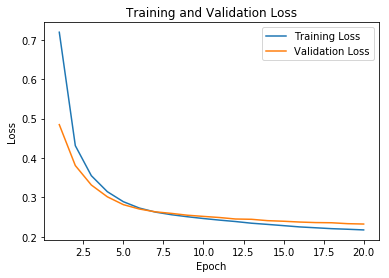

In [49]:
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']
epoch = range(1,21)
plt.plot(epoch,loss3,label='Training Loss')
plt.plot(epoch,val_loss3,label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

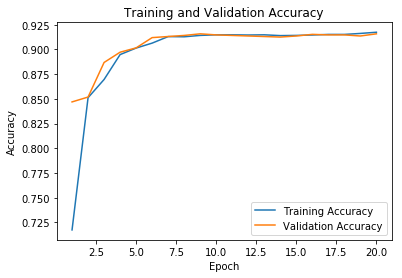

In [50]:
accuracy3 = history3.history['accuracy']
val_accuracy3 = history3.history['val_accuracy']
epoch = range(1,21)
plt.plot(epoch,accuracy3,label='Training Accuracy')
plt.plot(epoch,val_accuracy3,label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [51]:
results3 = model3.evaluate(x_test,y_test)
results3

2927/2927 [==============================] - 0s 21us/step


[0.23765476733741395, 0.9128800630569458]

### Model 4 (L1Regularization)

In [52]:
model4 = models.Sequential()
model4.add(layers.Dense(16,activity_regularizer = regularizers.l1(0.001),activation='relu',input_shape=(11,)))
model4.add(layers.Dense(16,activity_regularizer = regularizers.l1(0.001),activation='relu'))
model4.add(layers.Dense(1,activation='sigmoid'))
model4.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [53]:
history4 = model4.fit(x_train_keras,y_train_keras,epochs =20,validation_data = (x_val,y_val))

Train on 5000 samples, validate on 1829 samples
Epoch 1/20
5000/5000 [==============================] - 0s 77us/step - loss: 0.7662 - accuracy: 0.6792 - val_loss: 0.5806 - val_accuracy: 0.8453
Epoch 2/20
5000/5000 [==============================] - 0s 67us/step - loss: 0.5175 - accuracy: 0.8502 - val_loss: 0.4749 - val_accuracy: 0.8464
Epoch 3/20
5000/5000 [==============================] - 1s 110us/step - loss: 0.4364 - accuracy: 0.8508 - val_loss: 0.4175 - val_accuracy: 0.8469
Epoch 4/20
5000/5000 [==============================] - 1s 138us/step - loss: 0.3924 - accuracy: 0.8616 - val_loss: 0.3874 - val_accuracy: 0.8660
Epoch 5/20
5000/5000 [==============================] - 1s 136us/step - loss: 0.3671 - accuracy: 0.8848 - val_loss: 0.3688 - val_accuracy: 0.8786
Epoch 6/20
5000/5000 [==============================] - 1s 138us/step - loss: 0.3494 - accuracy: 0.8902 - val_loss: 0.3550 - val_accuracy: 0.8841
Epoch 7/20
5000/5000 [==============================] - 1s 137us/step - loss: 

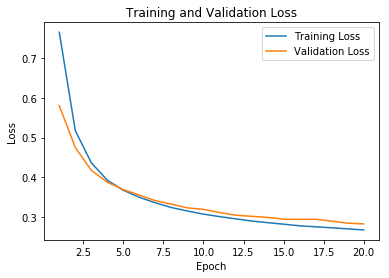

In [54]:
loss4 = history4.history['loss']
val_loss4 = history4.history['val_loss']
epoch = range(1,21)
plt.plot(epoch,loss4,label='Training Loss')
plt.plot(epoch,val_loss4,label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

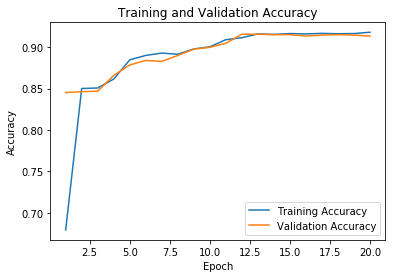

In [55]:
accuracy4 = history4.history['accuracy']
val_accuracy4 = history4.history['val_accuracy']
epoch = range(1,21)
plt.plot(epoch,accuracy4,label='Training Accuracy')
plt.plot(epoch,val_accuracy4,label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [56]:
results4 = model4.evaluate(x_test,y_test)
results4

2927/2927 [==============================] - 0s 20us/step


[0.2823529230741906, 0.9125384092330933]

### 5. Conclusion (Model Comparison)

In [59]:
Accuracy = pd.DataFrame({'Model':['Logistic','KNN','Classification Tree','Random Forest','XGBoost','NNet Original','NNet Dropout','NNet L1','NNet L2'],
                         'Accuracy':[Acc1,Acc2,Acc3,Acc4,Acc5,results1[1],results2[1],results3[1],results4[1]]}).sort_values('Accuracy',ascending = False)
Accuracy.reset_index(drop=True)

,Model,Accuracy
0,XGBoost,0.930987
1,Random Forest,0.928596
2,KNN,0.924838
3,NNet Original,0.918005
4,Classification Tree,0.916638
5,Logistic,0.913905
6,NNet Dropout,0.912880
7,NNet L1,0.912880
8,NNet L2,0.912538
